In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#importing dataset
df = pd.read_csv('../input/pima-indians-diabetes-database/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
df[df.Outcome==1].shape

(268, 9)

In [4]:
df[df.Outcome!=1].shape

(500, 9)

In [5]:
df_nomiss = df[(df['Glucose']!=0) & (df['BloodPressure']!=0) & (df['SkinThickness']!=0)  & (df['Insulin']!=0) & (df['BMI']!=0)]
df_miss  = df[(df['Glucose']==0) | (df['BloodPressure']==0) | (df['SkinThickness']==0)  | (df['Insulin']==0) | (df['BMI']==0)]

In [6]:
X_nomiss=df_nomiss.drop('Outcome',axis=1)
y_nomiss=df_nomiss['Outcome']

In [7]:
X_miss=df_miss.drop('Outcome',axis=1)
y_miss=df_miss['Outcome']

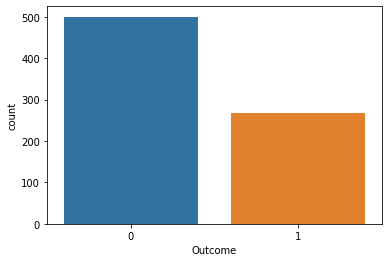

<Figure size 432x288 with 0 Axes>

In [8]:
sns.countplot(x=df["Outcome"])
plt.show()
plt.savefig('/kaggle/working/output.png')

In [9]:
from sklearn.model_selection import train_test_split
X_train_nomiss,X_test_nomiss,y_train_nomiss,y_test_nomiss =  train_test_split(X_nomiss,y_nomiss,test_size=0.20, random_state=7,stratify=y_nomiss)
X_train_miss,X_test_miss,y_train_miss,y_test_miss =  train_test_split(X_miss,y_miss,test_size=0.20, random_state=7,stratify=y_miss)

In [10]:
df_train_nomiss = pd.concat([X_train_nomiss,y_train_nomiss], axis=1)
df_train_miss = pd.concat([X_train_miss,y_train_miss], axis=1)

In [11]:
df_train = pd.concat([df_train_nomiss,df_train_miss], axis=0)

In [12]:
df_test_nomiss = pd.concat([X_test_nomiss,y_test_nomiss], axis=1)
df_test_miss = pd.concat([X_test_miss,y_test_miss], axis=1)

In [13]:
df_test = pd.concat([df_test_miss,df_test_miss], axis=0)

In [14]:
ms_col = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
for i in ms_col:
    x= df_train[(df_train[i]!=0)][i].median()
    print(x)
    df_train.loc[((df_train[i] == 0)), i] =  df_train[(df_train[i]!=0)][i].median()
    #df_train[ms_col].fillna(df_train[i].median())

117.0
72.0
29.0
125.0
32.0


In [15]:
df_test['Glucose'] = df_test['Glucose'].replace(0,117.0)
df_test['BloodPressure'] = df_test['BloodPressure'].replace(0,72.0)
df_test['SkinThickness'] = df_test['SkinThickness'].replace(0,29.0)
df_test['Insulin'] = df_test['Insulin'].replace(0,125.0)
df_test['BMI'] = df_test['BMI'].replace(0,32.0)

In [16]:
X_train=df_train.drop('Outcome',axis=1)
y_train=df_train['Outcome']
X_test=df_test.drop('Outcome',axis=1)
y_test=df_test['Outcome']

In [17]:
from sklearn.preprocessing import StandardScaler
scaling_x=StandardScaler()
X_train=scaling_x.fit_transform(X_train)
X_test=scaling_x.fit_transform(X_test)


In [18]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics  
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score

In [19]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=100,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27,
 use_label_encoder=False,  
 eval_metric='auc')

xgb1.fit(X_train, 
          y_train,
          eval_metric="auc")

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, eval_metric='auc', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, nthread=4, num_parallel_tree=1,
              predictor='auto', random_state=27, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=27, subsample=0.8, tree_method='exact',
              use_label_encoder=False, ...)

In [20]:
print("\nModel Report")
y_preds = xgb1.predict(X_test)
y_pred_proba = xgb1.predict_proba(X_test)[:,1]


y_preds1 = xgb1.predict(X_train)
y_pred_proba1 = xgb1.predict_proba(X_train)[:,1]

print('Accuracy (Train):', round(metrics.accuracy_score(y_train, y_preds1) * 100,2),'%')
print('Accuracy (Test):', round(metrics.accuracy_score(y_test, y_preds) * 100,2),'%')
print('AUC Score (Train):', round(metrics.roc_auc_score(y_train, y_pred_proba1) * 100,2),'%')
print('AUC Score (Test):', round(metrics.roc_auc_score(y_test, y_pred_proba) * 100,2),'%')



Model Report
Accuracy (Train): 98.69 %
Accuracy (Test): 76.32 %
AUC Score (Train): 99.87 %
AUC Score (Test): 82.51 %


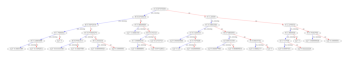

<Figure size 432x288 with 0 Axes>

In [21]:
from xgboost import plot_tree
plot_tree(xgb1)
plt.show()
plt.savefig('/kaggle/working/xgb1.png')

In [22]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(estimator=XGBClassifier(learning_rate =0.1,
                                                n_estimators=100,
                                                #max_depth=5,
                                                #min_child_weight=1,
                                                gamma=0,
                                                subsample=0.8,
                                                colsample_bytree=0.8,
                                                objective= 'binary:logistic',
                                                nthread=4,
                                                scale_pos_weight=1,
                                                seed=27,
                                                use_label_encoder=False,  
                                                eval_metric='auc'),
                        param_grid = param_test1, 
                        scoring='roc_auc',
                        n_jobs=4,
                        cv=5)
eval_set = [(X_test, y_test)]

gsearch1.fit(X_train, y_train,early_stopping_rounds=5,eval_set=eval_set)
print("Tuned Paramerers ==> ",gsearch1.best_params_)
print("Best Score ==> ",gsearch1.best_score_)
print("Accuracy on Train set ==> ", gsearch1.score(X_train,y_train))
print("Accuracy on Test1 set ==> ", gsearch1.score(X_test,y_test))


[0]	validation_0-auc:0.69234
[0]	validation_0-auc:0.74405
[1]	validation_0-auc:0.78051
[1]	validation_0-auc:0.81510
[2]	validation_0-auc:0.80804
[2]	validation_0-auc:0.81771
[3]	validation_0-auc:0.82664
[3]	validation_0-auc:0.83147
[4]	validation_0-auc:0.83259
[4]	validation_0-auc:0.82850
[5]	validation_0-auc:0.81473
[5]	validation_0-auc:0.84561
[6]	validation_0-auc:0.84747
[7]	validation_0-auc:0.83854
[8]	validation_0-auc:0.83817
[9]	validation_0-auc:0.82998
[10]	validation_0-auc:0.83668
[6]	validation_0-auc:0.82887
[7]	validation_0-auc:0.82812
[8]	validation_0-auc:0.81957
[0]	validation_0-auc:0.74144
[0]	validation_0-auc:0.77083
[1]	validation_0-auc:0.74554
[2]	validation_0-auc:0.77158
[1]	validation_0-auc:0.76525
[2]	validation_0-auc:0.77232
[3]	validation_0-auc:0.79725
[3]	validation_0-auc:0.78609
[4]	validation_0-auc:0.82217
[4]	validation_0-auc:0.80283
[5]	validation_0-auc:0.81510
[5]	validation_0-auc:0.83222
[6]	validation_0-auc:0.83743
[6]	validation_0-auc:0.82664
[7]	validatio

In [23]:
param_test2 = {
 'n_estimators':range(100,2000,25)
}

gsearch2 = GridSearchCV(estimator=XGBClassifier(learning_rate =0.1,
                                                #n_estimators=100,
                                                max_depth=3,
                                                min_child_weight=5,
                                                gamma=0,
                                                subsample=0.8,
                                                colsample_bytree=0.8,
                                                objective= 'binary:logistic',
                                                nthread=4,
                                                scale_pos_weight=1,
                                                seed=27,
                                                use_label_encoder=False,  
                                                eval_metric='auc'),
                        param_grid = param_test2, 
                        scoring='roc_auc',
                        n_jobs=4,
                        cv=5)
eval_set = [(X_test, y_test)]

gsearch2.fit(X_train, y_train,early_stopping_rounds=5,eval_set=eval_set)
print("Tuned Paramerers ==> ",gsearch2.best_params_)
print("Best Score ==> ",gsearch2.best_score_)
print("Accuracy on Train set ==> ", gsearch2.score(X_train,y_train))
print("Accuracy on Test1 set ==> ", gsearch2.score(X_test,y_test))


[0]	validation_0-auc:0.73772
[1]	validation_0-auc:0.80990
[2]	validation_0-auc:0.82961
[3]	validation_0-auc:0.84375
[0]	validation_0-auc:0.74851
[4]	validation_0-auc:0.84412
[5]	validation_0-auc:0.85231
[0]	validation_0-auc:0.78981
[0]	validation_0-auc:0.73252
[6]	validation_0-auc:0.84821
[7]	validation_0-auc:0.86161
[1]	validation_0-auc:0.79018
[8]	validation_0-auc:0.84821
[1]	validation_0-auc:0.78051
[1]	validation_0-auc:0.74182
[9]	validation_0-auc:0.84301
[10]	validation_0-auc:0.84449
[2]	validation_0-auc:0.79502
[2]	validation_0-auc:0.80506
[11]	validation_0-auc:0.84449
[2]	validation_0-auc:0.76339
[12]	validation_0-auc:0.84673
[3]	validation_0-auc:0.80766
[3]	validation_0-auc:0.79911
[3]	validation_0-auc:0.81622
[4]	validation_0-auc:0.81659
[4]	validation_0-auc:0.81882
[5]	validation_0-auc:0.83371
[4]	validation_0-auc:0.81027
[5]	validation_0-auc:0.82031
[6]	validation_0-auc:0.84115
[5]	validation_0-auc:0.80580
[6]	validation_0-auc:0.84375
[7]	validation_0-auc:0.84338
[7]	validat

In [24]:
param_test4 = {
 'gamma':[i/10.0 for i in range(0,5)],
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator=XGBClassifier(learning_rate =0.1,
                                                n_estimators=100,
                                                max_depth=3,
                                                min_child_weight=5,
                                                #gamma=0,
                                                #subsample=0.8,
                                                #colsample_bytree=0.8,
                                                objective= 'binary:logistic',
                                                nthread=4,
                                                scale_pos_weight=1,
                                                seed=27,
                                                use_label_encoder=False,  
                                                eval_metric='auc'),
                        param_grid = param_test4, 
                        scoring='roc_auc',
                        n_jobs=4,
                        cv=5)
eval_set = [(X_test, y_test)]
gsearch4.fit(X_train, y_train,early_stopping_rounds=5,eval_set=eval_set)
print("Tuned Paramerers ==> ",gsearch4.best_params_)
print("Best Score ==> ",gsearch4.best_score_)
print("Accuracy on Train set ==> ", gsearch4.score(X_train,y_train))
print("Accuracy on Test set ==> ", gsearch4.score(X_test,y_test))


[0]	validation_0-auc:0.63728
[1]	validation_0-auc:0.82812
[0]	validation_0-auc:0.63691
[2]	validation_0-auc:0.84115
[1]	validation_0-auc:0.76934
[3]	validation_0-auc:0.79613
[4]	validation_0-auc:0.83966
[2]	validation_0-auc:0.78385
[3]	validation_0-auc:0.77753
[5]	validation_0-auc:0.84375
[4]	validation_0-auc:0.78795
[5]	validation_0-auc:0.77753
[6]	validation_0-auc:0.82143
[6]	validation_0-auc:0.77232
[7]	validation_0-auc:0.83296
[7]	validation_0-auc:0.80059
[8]	validation_0-auc:0.82403
[8]	validation_0-auc:0.79762
[9]	validation_0-auc:0.80655
[9]	validation_0-auc:0.82403
[10]	validation_0-auc:0.81920
[11]	validation_0-auc:0.82887
[10]	validation_0-auc:0.83891
[0]	validation_0-auc:0.64137
[1]	validation_0-auc:0.74777
[2]	validation_0-auc:0.78943
[12]	validation_0-auc:0.82664
[0]	validation_0-auc:0.59784
[3]	validation_0-auc:0.79725
[1]	validation_0-auc:0.79613
[13]	validation_0-auc:0.81994
[2]	validation_0-auc:0.77121
[4]	validation_0-auc:0.82478
[3]	validation_0-auc:0.81734
[14]	vali

In [25]:
param_test6 = {
 'nthread':range(1,10,1),
}
gsearch6 = GridSearchCV(estimator=XGBClassifier(learning_rate =0.1,
                                                n_estimators=100,
                                                max_depth=3,
                                                min_child_weight=5,
                                                gamma=0.0,
                                                subsample=0.9,
                                                colsample_bytree=0.6,
                                                objective= 'binary:logistic',
                                                #nthread=4,
                                                scale_pos_weight=1,
                                                seed=27,
                                                use_label_encoder=False,  
                                                eval_metric='auc'),
                        param_grid = param_test6, 
                        scoring='roc_auc',
                        n_jobs=4,
                        cv=5)
eval_set = [(X_test, y_test)]
gsearch6.fit(X_train, y_train,early_stopping_rounds=5,eval_set=eval_set)
print("Tuned Paramerers ==> ",gsearch6.best_params_)
print("Best Score ==> ",gsearch6.best_score_)
print("Accuracy on Train set ==> ", gsearch6.score(X_train,y_train))
print("Accuracy on Test set ==> ", gsearch6.score(X_test,y_test))


[0]	validation_0-auc:0.61793
[1]	validation_0-auc:0.78720
[2]	validation_0-auc:0.79576
[3]	validation_0-auc:0.79948
[4]	validation_0-auc:0.82850
[5]	validation_0-auc:0.82589
[6]	validation_0-auc:0.82031
[7]	validation_0-auc:0.82031
[8]	validation_0-auc:0.80990
[9]	validation_0-auc:0.80952
[0]	validation_0-auc:0.60342
[1]	validation_0-auc:0.72991
[2]	validation_0-auc:0.75260
[3]	validation_0-auc:0.74888
[0]	validation_0-auc:0.65179
[4]	validation_0-auc:0.79985
[1]	validation_0-auc:0.75595
[2]	validation_0-auc:0.78348
[3]	validation_0-auc:0.74479
[4]	validation_0-auc:0.79129
[5]	validation_0-auc:0.78981
[5]	validation_0-auc:0.79167
[6]	validation_0-auc:0.80022
[6]	validation_0-auc:0.77753
[7]	validation_0-auc:0.79836
[7]	validation_0-auc:0.79502
[8]	validation_0-auc:0.80506
[8]	validation_0-auc:0.80469
[9]	validation_0-auc:0.79873
[9]	validation_0-auc:0.80134
[10]	validation_0-auc:0.81213
[11]	validation_0-auc:0.82180
[12]	validation_0-auc:0.82180
[0]	validation_0-auc:0.60677
[13]	valida

In [26]:
param_test7 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch7 = GridSearchCV(estimator=XGBClassifier(learning_rate =0.1,
                                                n_estimators=100,
                                                max_depth=3,
                                                min_child_weight=5,
                                                gamma=0.0,
                                                subsample=0.9,
                                                colsample_bytree=0.6,
                                                #reg_alpha=,
                                                objective= 'binary:logistic',
                                                nthread=1,
                                                scale_pos_weight=1,
                                                seed=27,
                                                use_label_encoder=False,  
                                                eval_metric='auc'),
                        param_grid = param_test7, 
                        scoring='roc_auc',
                        n_jobs=4,
                        cv=5)
eval_set = [(X_test, y_test)]
gsearch7.fit(X_train, y_train,early_stopping_rounds=5,eval_set=eval_set)
print("Tuned Paramerers ==> ",gsearch7.best_params_)
print("Best Score ==> ",gsearch7.best_score_)
print("Accuracy on Train set ==> ", gsearch7.score(X_train,y_train))
print("Accuracy on Test set ==> ", gsearch7.score(X_test,y_test))


[0]	validation_0-auc:0.60342
[0]	validation_0-auc:0.65179
[0]	validation_0-auc:0.61793
[1]	validation_0-auc:0.75595
[2]	validation_0-auc:0.78348
[1]	validation_0-auc:0.78720
[1]	validation_0-auc:0.72991
[2]	validation_0-auc:0.79576
[3]	validation_0-auc:0.74479
[4]	validation_0-auc:0.79129
[5]	validation_0-auc:0.78981
[6]	validation_0-auc:0.80022
[7]	validation_0-auc:0.79836
[8]	validation_0-auc:0.80506
[2]	validation_0-auc:0.75260
[9]	validation_0-auc:0.80134
[3]	validation_0-auc:0.79948
[3]	validation_0-auc:0.74888
[10]	validation_0-auc:0.81213
[4]	validation_0-auc:0.79985
[11]	validation_0-auc:0.82180
[4]	validation_0-auc:0.82850
[12]	validation_0-auc:0.82180
[5]	validation_0-auc:0.82589
[13]	validation_0-auc:0.80990
[5]	validation_0-auc:0.79167
[14]	validation_0-auc:0.81287
[6]	validation_0-auc:0.77753
[6]	validation_0-auc:0.82031
[15]	validation_0-auc:0.81882
[16]	validation_0-auc:0.81585
[7]	validation_0-auc:0.82031
[7]	validation_0-auc:0.79502
[8]	validation_0-auc:0.80469
[9]	val

In [27]:
param_test8 = {
 'learning_rate':[i/100.0 for i in range(1,10)]
}
gsearch8 = GridSearchCV(estimator=XGBClassifier(#learning_rate =0.1,
                                                n_estimators=100,
                                                max_depth=3,
                                                min_child_weight=5,
                                                gamma=0.0,
                                                subsample=0.9,
                                                colsample_bytree=0.6,
                                                reg_alpha= 0.1,
                                                objective= 'binary:logistic',
                                                nthread=4,
                                                scale_pos_weight=1,
                                                seed=27,
                                                use_label_encoder=False,  
                                                eval_metric='auc'),
                        param_grid = param_test8, 
                        scoring='roc_auc',
                        n_jobs=4,
                        cv=5)
eval_set = [(X_test, y_test)]
gsearch8.fit(X_train, y_train,early_stopping_rounds=5,eval_set=eval_set)
print("Tuned Paramerers ==> ",gsearch8.best_params_)
print("Best Score ==> ",gsearch8.best_score_)
print("Accuracy on Train set ==> ", gsearch8.score(X_train,y_train))
print("Accuracy on Test1 set ==> ", gsearch8.score(X_test,y_test))


[0]	validation_0-auc:0.60677
[0]	validation_0-auc:0.61793
[0]	validation_0-auc:0.60342
[1]	validation_0-auc:0.77455
[0]	validation_0-auc:0.65179
[1]	validation_0-auc:0.73214
[2]	validation_0-auc:0.79539
[2]	validation_0-auc:0.75260
[3]	validation_0-auc:0.74516
[1]	validation_0-auc:0.75521
[3]	validation_0-auc:0.78348
[1]	validation_0-auc:0.77753
[4]	validation_0-auc:0.78311
[5]	validation_0-auc:0.77865
[6]	validation_0-auc:0.78311
[2]	validation_0-auc:0.79092
[7]	validation_0-auc:0.80394
[8]	validation_0-auc:0.80469
[4]	validation_0-auc:0.81510
[5]	validation_0-auc:0.82329
[3]	validation_0-auc:0.75484
[9]	validation_0-auc:0.80022
[6]	validation_0-auc:0.81362
[10]	validation_0-auc:0.81362
[4]	validation_0-auc:0.80432
[2]	validation_0-auc:0.77307
[7]	validation_0-auc:0.81138
[11]	validation_0-auc:0.82478
[12]	validation_0-auc:0.83110
[13]	validation_0-auc:0.82812
[14]	validation_0-auc:0.82738
[15]	validation_0-auc:0.82068
[16]	validation_0-auc:0.81548
[5]	validation_0-auc:0.80134
[3]	val

In [28]:
param_test9 = {
 'learning_rate':[i/100.0 for i in range(7,50)]
}
gsearch9 = GridSearchCV(estimator=XGBClassifier(#learning_rate =0.1,
                                                n_estimators=100,
                                                max_depth=3,
                                                min_child_weight=5,
                                                gamma=0.0,
                                                subsample=0.9,
                                                colsample_bytree=0.6,
                                                reg_alpha= 0.1,
                                                objective= 'binary:logistic',
                                                nthread=4,
                                                scale_pos_weight=1,
                                                seed=27,
                                                use_label_encoder=False,  
                                                eval_metric='auc'),
                        param_grid = param_test9, 
                        scoring='roc_auc',
                        n_jobs=4,
                        cv=5)
eval_set = [(X_test, y_test)]
gsearch9.fit(X_train, y_train,early_stopping_rounds=5,eval_set=eval_set)
print("Tuned Paramerers ==> ",gsearch9.best_params_)
print("Best Score ==> ",gsearch9.best_score_)
print("Accuracy on Train set ==> ", gsearch9.score(X_train,y_train))
print("Accuracy on Test1 set ==> ", gsearch9.score(X_test,y_test))


[0]	validation_0-auc:0.61793
[0]	validation_0-auc:0.60342
[1]	validation_0-auc:0.72991
[1]	validation_0-auc:0.78720
[2]	validation_0-auc:0.79464
[2]	validation_0-auc:0.75260
[0]	validation_0-auc:0.65179
[3]	validation_0-auc:0.79650
[3]	validation_0-auc:0.74888
[1]	validation_0-auc:0.75595
[4]	validation_0-auc:0.78460
[4]	validation_0-auc:0.82664
[2]	validation_0-auc:0.78348
[5]	validation_0-auc:0.78088
[6]	validation_0-auc:0.77195
[7]	validation_0-auc:0.78646
[3]	validation_0-auc:0.75558
[5]	validation_0-auc:0.82812
[4]	validation_0-auc:0.79613
[8]	validation_0-auc:0.79316
[6]	validation_0-auc:0.82217
[5]	validation_0-auc:0.79650
[9]	validation_0-auc:0.78795
[7]	validation_0-auc:0.82217
[6]	validation_0-auc:0.79799
[10]	validation_0-auc:0.80618
[11]	validation_0-auc:0.81436
[12]	validation_0-auc:0.81882
[0]	validation_0-auc:0.60677
[8]	validation_0-auc:0.81510
[7]	validation_0-auc:0.80580
[13]	validation_0-auc:0.81957
[1]	validation_0-auc:0.77827
[14]	validation_0-auc:0.82106
[9]	valid

In [29]:
param_test10 = {
 'scale_pos_weight':range(1,8,1)
}
gsearch10 = GridSearchCV(estimator=XGBClassifier(learning_rate =0.12,
                                                n_estimators=100,
                                                max_depth=3,
                                                min_child_weight=5,
                                                gamma=0.0,
                                                subsample=0.9,
                                                colsample_bytree=0.6,
                                                reg_alpha= 0.1,
                                                objective= 'binary:logistic',
                                                nthread=4,
                                                #scale_pos_weight=1,
                                                seed=27,
                                                use_label_encoder=False,  
                                                eval_metric='auc'),
                        param_grid = param_test10, 
                        scoring='roc_auc',
                        n_jobs=4,
                        cv=5)
eval_set = [(X_test, y_test)]
gsearch10.fit(X_train, y_train,early_stopping_rounds=5,eval_set=eval_set)
print("Tuned Paramerers ==> ",gsearch10.best_params_)
print("Best Score ==> ",gsearch10.best_score_)
print("Accuracy on Train set ==> ", gsearch10.score(X_train,y_train))
print("Accuracy on Test set ==> ", gsearch10.score(X_test,y_test))


[0]	validation_0-auc:0.60342
[0]	validation_0-auc:0.61793
[1]	validation_0-auc:0.73809
[0]	validation_0-auc:0.65179
[1]	validation_0-auc:0.78720
[1]	validation_0-auc:0.76042
[2]	validation_0-auc:0.76079
[2]	validation_0-auc:0.79762
[2]	validation_0-auc:0.78571
[3]	validation_0-auc:0.74963
[3]	validation_0-auc:0.80097
[3]	validation_0-auc:0.77307
[4]	validation_0-auc:0.80134
[4]	validation_0-auc:0.82552
[5]	validation_0-auc:0.79167
[4]	validation_0-auc:0.80097
[5]	validation_0-auc:0.82887
[6]	validation_0-auc:0.78348
[6]	validation_0-auc:0.82031
[5]	validation_0-auc:0.79911
[7]	validation_0-auc:0.81957
[7]	validation_0-auc:0.79353
[6]	validation_0-auc:0.81176
[8]	validation_0-auc:0.81064
[8]	validation_0-auc:0.80283
[9]	validation_0-auc:0.81250
[9]	validation_0-auc:0.80357
[7]	validation_0-auc:0.81585
[10]	validation_0-auc:0.81287
[0]	validation_0-auc:0.60677
[11]	validation_0-auc:0.82701
[1]	validation_0-auc:0.75260
[12]	validation_0-auc:0.83296
[2]	validation_0-auc:0.75856
[13]	valida

In [30]:
xgb =XGBClassifier(learning_rate =0.12,
                   n_estimators=100,
                   max_depth=3,
                   min_child_weight=5,
                   gamma=0.0,
                   subsample=0.9,
                   colsample_bytree=0.6,
                   objective= 'binary:logistic',
                   nthread=4,
                   scale_pos_weight=1,
                   seed=27,
                   use_label_encoder=False,  
                   eval_metric='auc')
xgb.fit(X_train, y_train,early_stopping_rounds=5,eval_set=eval_set)

print("\nModel Report")
y_predsx = xgb.predict(X_test)
y_predx_proba = xgb.predict_proba(X_test)[:,1]


y_preds1x = xgb.predict(X_train)
y_predx_proba1 = xgb.predict_proba(X_train)[:,1]

print('Accuracy (Train):', round(metrics.accuracy_score(y_train, y_preds1x) * 100,2),'%')
print('Accuracy (Test):', round(metrics.accuracy_score(y_test, y_predsx) * 100,2),'%')
print('AUC Score (Train):', round(metrics.roc_auc_score(y_train, y_predx_proba1) * 100,2),'%')
print('AUC Score (Test):', round(metrics.roc_auc_score(y_test, y_predx_proba) * 100,2),'%')


[0]	validation_0-auc:0.59524
[1]	validation_0-auc:0.66109
[2]	validation_0-auc:0.78460
[3]	validation_0-auc:0.82403
[4]	validation_0-auc:0.82664
[5]	validation_0-auc:0.84115
[6]	validation_0-auc:0.84115
[7]	validation_0-auc:0.84115
[8]	validation_0-auc:0.83519
[9]	validation_0-auc:0.84263
[10]	validation_0-auc:0.83929
[11]	validation_0-auc:0.84152
[12]	validation_0-auc:0.84598
[13]	validation_0-auc:0.84003
[14]	validation_0-auc:0.83408
[15]	validation_0-auc:0.83780
[16]	validation_0-auc:0.83929

Model Report
Accuracy (Train): 80.75 %
Accuracy (Test): 81.58 %
AUC Score (Train): 89.01 %
AUC Score (Test): 84.6 %


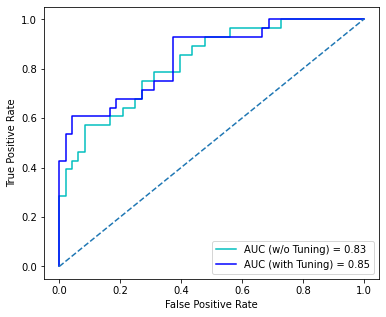

In [31]:
from sklearn.metrics import roc_curve, roc_auc_score
y_score1 = xgb1.predict_proba(X_test)[:,1]
fpr1, tpr1, th1 = roc_curve(y_test, y_score1)
y_score2 = xgb.predict_proba(X_test)[:,1]
fpr2, tpr2, th2 = roc_curve(y_test, y_score2)
#print('roc_auc_score before tuning: ', roc_auc_score(y_test, y_score2))  
#print('roc_auc_score after tuning: ', roc_auc_score(y_test, y_score1))  
roc_auc1 = roc_auc_score(y_test, y_score1)
roc_auc2 = roc_auc_score(y_test, y_score2)
plt.subplots(1, figsize=(6,5))
plt.plot(fpr1, tpr1, 'c', label = 'AUC (w/o Tuning) = %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, 'b', label = 'AUC (with Tuning) = %0.2f' % roc_auc2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.show()